# Strip-AI with ResNet CNN

## Overview
This notebook is a practice of utilizing the TensorFlow and Keras to build a Convolutional Neural Network (CNN) for predicting cancer detection from digital pathology images. The practice is based on a Kaggle competition, and the data can be obtained from the competition website at https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data#:~:text=Download-,All,-navigate_next.

This notebook can also be found at https://github.com/Lorby04/msds/tree/main/dl/week3 and https://www.kaggle.com/code/lorbybi/cnn-histopathologic-cancer-detection

1. Data preparing

Downloading data from the source, extract the compressed files to local disk.
The original image is in tiff format which is not supported by tensorflow. Although there's other packages can handle the format, but it requires mandy dependecies which makes the image loading tasks being complex. To simplify the procedure, finally I converted the tiff image to jpeg format with the package Pillow. 
After the images are prepared, I'm planning to use the Keras API "image_dataset_from_directory()" to create tensorflow dataset from the directory. The API requires the directories to be organized hierarchically with subdirectory to be the name of the class_name or label. So, the hierarchical directory is created along with the downloading/converting/saving procedure as the implemention in the below cells.

In [12]:
import pathlib
import os
import sys
import concurrent.futures

import pandas as pd
from PIL import Image

import numpy as np
import random as rn

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_io as tfio
import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer

In [13]:
class Constants:
    QUICK_TEST = False
    MAX_FILES = 10
    TARGET_SIZE = [1024,1024]
    BATCH_SIZE = 1
    
class Config():
    def __init__(self):
        self.dataset_url = "https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data#:~:text=Download-,All,-navigate_next"
        self.data_root_dir =  "/kaggle/input/mayo-clinic-strip-ai/"
        self.working_dir = "/kaggle/working/"
        self.temp_dir = "/kaggle/working/temp/"

        if os.path.exists("/kaggle"):
            print("Working in kaggle notebook enviorment")
        else:
            print("Working locally")
            self.data_root_dir =  "./asl-signs/"
            self.working_dir = data_root_dir
            self.temp_dir = working_dir

        self.temp_train_dir = self.temp_dir + "train/"
        self.temp_test_dir = self.temp_dir + "test/"
        
        self.data_dir = self.data_root_dir

        self.train_csv =  self.data_dir + "train.csv"
        self.test_csv = self.data_dir + "test.csv"
        self.other_csv = self.data_dir + "other.csv"

        self.origin_train_dir = self.data_dir + "train/"
        self.origin_test_dir = self.data_dir + "test/"

        self.train_dir = self.data_dir + "train/"
        self.test_dir = self.data_dir + "test/"
        self.other_dir = self.data_dir + "other/"

        self.dir_true = self.train_dir + "1/"
        self.dir_false = self.train_dir + "0/"

        self.origin_train_path = pathlib.Path(self.origin_train_dir).with_suffix('')
        self.origin_test_path = pathlib.Path(self.origin_test_dir).with_suffix('')

        self.train_path = pathlib.Path(self.train_dir).with_suffix('')
        self.test_path = pathlib.Path(self.test_dir).with_suffix('')
    
    def download_data(self):
        if not os.path.exists(self.data_dir):
            cmd = "pip install opendatasets"
            os.system(cmd)
            import opendatasets as od
            od.download(self.dataset_url)
        

In [14]:
config = Config()
config.download_data()

Working in kaggle notebook enviorment


Only perform the data preparing for the first time

In [15]:
class Df():
    def __init__(self, 
                 cfg:Config
                ):
        self.train_df = pd.read_csv(cfg.train_csv).dropna()
        self.test_df = pd.read_csv(cfg.test_csv)
        self.other_df = pd.read_csv(cfg.other_csv)
        self.other_df['label'] = self.other_df['label'].where(
            self.other_df['label']=='Unknown', 
            self.other_df['label']+'-'+ self.other_df['other_specified']
        )
        self.other_df.drop(['other_specified'], axis = 1, inplace=True)
        self.other_df.dropna(inplace = True)
        self.combined_train_df = None
        
    def combine_train_set(self):
        pass
    def glance_at(self, df):
        print("\nQuick view of {} data set".format(df))
        if df == 'train':
            print(self.train_df)
            self.train_df.info()
            print('Target values:')
            
            vc = self.train_df['label'].value_counts()     
            print(vc)
            plt.pie(vc,autopct='%1.1f%%')
            plt.legend(vc.index, loc='best')
            plt.show()
        elif df == 'test':
            print(self.test_df)
            self.test_df.info()
        else:
            print(self.other_df)
            self.other_df.info()
            print('Target values:\n')
            vc = self.other_df['label'].value_counts()     
            print(vc)
            plt.pie(vc,autopct='%1.1f%%')
            plt.legend(vc.index, loc='best')
            plt.show()
            
    def glance(self):
        self.glance_at('train')
        self.glance_at('test')
        self.glance_at('other')



Quick view of train data set
     image_id  center_id patient_id  image_num label
0    006388_0         11     006388          0    CE
1    008e5c_0         11     008e5c          0    CE
2    00c058_0         11     00c058          0   LAA
3    01adc5_0         11     01adc5          0   LAA
4    026c97_0          4     026c97          0    CE
..        ...        ...        ...        ...   ...
749  fe9645_0          3     fe9645          0    CE
750  fe9bec_0          4     fe9bec          0   LAA
751  ff14e0_0          6     ff14e0          0    CE
752  ffec5c_0          7     ffec5c          0   LAA
753  ffec5c_1          7     ffec5c          1   LAA

[754 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   i

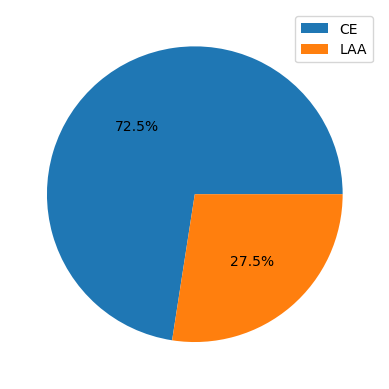


Quick view of test data set
   image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes

Quick view of other data set
     image_id patient_id  image_num                  label
0    01f2b3_0     01f2b3          0                Unknown
1    01f2b3_1     01f2b3          1                Unknown
2    02ebd5_0     02ebd5          0                Unknown
3    0412ab_0     0412ab          0                Unknown
4    04414e_0     04414e  

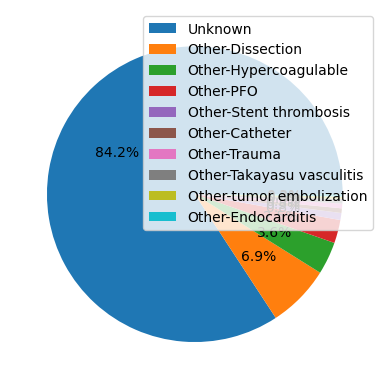

In [16]:
df = Df(config)
df.glance()

In [17]:
class ImageRawDataInMemory:
    def __init__(self, 
                 df, 
                 path, 
                 dumypath,
                 target_size = Constants.TARGET_SIZE, 
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.path = path
        self.target_size = target_size
        self.max_images = min(len(df), Constants.MAX_FILES)
        self.quick_test = quick_test
        if (quick_test):
            self.max_images = min(4, len(df))
        self.imgs = [None]*self.max_images #List of (img, label, image_id)
        self.loaded_images = 0
        self.is_training = 'label' in df.columns
        
        
class ImageLoaderInMemory:
    def build(df, 
             path, 
             dumypath,
             target_size = Constants.TARGET_SIZE, 
             quick_test = Constants.QUICK_TEST):
        owner = ImageRawDataInMemory(df,
                                   path,
                                   dumypath,
                                   target_size,
                                   quick_test)
        
        loader = ImageLoaderInMemory(owner)
        loader.build_dataset(imgs,training_ratio)
        return loader
    
    def __init__(self,owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
    
    
    def load_image(self,file):
        backup = Image.MAX_IMAGE_PIXELS
        Image.MAX_IMAGE_PIXELS = None

        img = None
        with Image.open(file) as f:
            img = f.resize(self.owner().target_size,Image.Resampling.LANCZOS)

        Image.MAX_IMAGE_PIXELS = backup
        return img

    # The loading is done in a separated process
    # Since the notebook is designed to be run in sequencial mode, no lock is needed
    def load_one(self, id):
        fn = self.owner().path + str(id) + '.tif'
        img = None
        with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
            future = executor.submit(self.load_image, fn)
            img = future.result()
        return img
    
    # load all images in the specified directory, resize to small size, store the resized copy
    def load(self):       
        start = timer()

        self.owner().loaded_images = 0
        self.owner().imgs = [None]*self.owner().max_images
        
        loop_start = timer()
        indice = rn.sample(range(0, len(self.owner().df)), self.owner().max_images)
        for i in indice:
            img = self.load_one(self.owner().df.loc[i]['image_id'])
            if self.owner().quick_test:
                print("Loaded a image {}:{}".format(self.owner().df.loc[i]['image_id'],img))
            else:
                print('.', end = ' ')

            if self.owner().is_training:
                self.owner().imgs[self.owner().loaded_images] = [img, self.owner().df.loc[i]['image_id'], self.owner().df.loc[i]['label']]
            else:
                self.owner().imgs[self.owner().loaded_images] = [img, self.owner().df.loc[i]['image_id'], None]
                
            self.owner().loaded_images += 1
        
        elapsed = timer() - start

        print("{} images are loaded from {} in {} seconds".format(self.owner().loaded_images, self.owner().path, elapsed))
            
    def show_images(self):
        num = min(2, self.owner().loaded_images)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        indice = rn.sample(range(0, self.owner().loaded_images), num)
        print(indice)
        for i in range(len(indice)):
            img = self.owner().imgs[indice[i]]
            ax[i].imshow(img[0])
            ax[i].set_title(img[1]+ ('' if img[2]==None else ' '+img[2]))
            i += 1
            if i >= num:
                return
    
    def pick_one(self):
        if self.owner().loaded_images == 0:
            return None
        index = rn.sample(range(0, self.owner().loaded_images), 1)[0]
        return self.owner().imgs[index]
    
    def statistics(self):
        print("{} images are loaded from {}".format(self.owner().loaded_images, self.owner().path))

In [18]:
class DatasetInMemory:
    def __init__(self, imgs, training_ratio = 0.8):
        self.img_set = None # [[img_tensor, id, label]*N]
        self.size = 0
        for images in imgs:
            self.size += images.loaded_images
    
        self.tensors = [None]*self.size
        self.length = 0
        
        self.ds = None
        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None

        
class DatasetBuilderFromMemory:
    def build(imgs, training_ratio = 0.8):
        owner = DatasetInMemory(imgs, training_ratio)
        
        builder = DatasetBuilderFromMemory(owner)
        builder.build_dataset(imgs,training_ratio)
        return builder
    
    def __init__(self,owner=None):
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
                
        
    def build_dataset(self, imgs, training_ratio):
        self.owner().length = 0
        self.owner().tensors = [None]*self.owner().size
        self.owner().img_set = None
        for ims in imgs:
            if self.owner().img_set == None:
                self.owner().img_set = ims.imgs.copy()
            else:
                self.owner().img_set.extend(ims.imgs.copy())
        if self.owner().img_set[0][2] == None: # Test set, no labels ready
            pass
        for i in range(len(self.owner().img_set)):
            self.owner().img_set[i][0] = tf.convert_to_tensor(self.owner().img_set[i][0])
    
        
        img_list, id_list, label_list = zip(*self.owner().img_set)
        if label_list[0] != None:
            img_ds = tf.data.Dataset.from_tensor_slices(img_list)
            label_ds = tf.data.Dataset.from_tensors(label_list)
            self.owner().ds = tf.data.Dataset.zip(img_ds, label_ds)
            
            
            skip_count = int(training_ratio * (1-len(self.owner().img_set)))
            self.owner().train_ds_=self.owner().ds.skip(skip_count).batch(Constants.BATCH_SIZE)
            self.owner().val_ds_ = self.owner().ds.take(skip_count).batch(Constants.BATCH_SIZE)
        else:
            self.owner().ds = tf.data.Dataset.from_tensors((img_list))
            self.owner().test_ds_ = self.owner().ds.batch(Constants.BATCH_SIZE)
            
    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            #print(b)
            for img, label in b:
                ax[i].imshow(img)
                ax[i].set_title("Label:" + label)
                i += 1
                if i >= num:
                    return                

    def show_test_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            for img in b:
                ax[i].imshow(img)
                ax[i].set_title("Test image")
                i += 1
                if i >= num:
                    return  
                
    def show_images(self):
        if self.owner().train_ds_ != None:
            self.show_train_images(self.owner().train_ds_, 1)
            assert(self.owner().val_ds_ != None)
            self.show_train_images(self.owner().val_ds_,1)
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_images(self.owner().test_ds_, 2)
                
    def statistics(self):
        print(self.owner().imgs)
        print("Expected tensors:{}, real tensors:{}".format(self.owner().size, self.owner().length))

In [19]:
def check_create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        pass
   

class ImageRawDataInDisk:
    def __init__(self, 
                 df, 
                 from_path,
                 to_path,
                 target_size = Constants.TARGET_SIZE, 
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.from_path = from_path
        self.to_path = to_path
        self.target_size = target_size
        self.max_images = min(len(df), Constants.MAX_FILES)
        self.quick_test = quick_test
        if (quick_test):
            self.max_images = min(4, len(df))
        self.loaded_images = 0
        self.skipped_images = 0
        self.is_training = 'label' in df.columns
        
class ImageLoaderToDisk:    
    def build(df, 
             from_path,
             to_path,
             target_size = Constants.TARGET_SIZE, 
             quick_test = Constants.QUICK_TEST):
        owner = ImageRawDataInDisk(df, 
                 from_path,
                 to_path,
                 target_size, 
                 quick_test)
        check_create_dir(to_path)
        loader = ImageLoaderToDisk(owner)
        loader.load()
        return loader
    
    def __init__(self, owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
                
        
    def load_image(self, from_file, to_file):
        backup = Image.MAX_IMAGE_PIXELS
        Image.MAX_IMAGE_PIXELS = None

        with Image.open(from_file) as f:
            img = f.resize(self.owner().target_size,Image.Resampling.LANCZOS)
            img.save(to_file)

        Image.MAX_IMAGE_PIXELS = backup
        return True

    # The loading is done in a separated process
    # Since the notebook is designed to be run in sequencial mode, no lock is needed
    def load_one(self, from_file, to_file):
        success = False
        with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
            future = executor.submit(self.load_image, from_file, to_file)
            success = future.result()
        return success
    
    # load all images in the specified directory, resize to small size, store the resized copy
    def load(self):       
        start = timer()

        self.owner().loaded_images = 0
        self.owner().imgs = [None]*self.owner().max_images
        
        loop_start = timer()
        
        to_dir = self.owner().to_path
        indice = rn.sample(range(0, len(self.owner().df)), self.owner().max_images)
        for i in indice:
            id = self.owner().df.loc[i]['image_id']
            if self.owner().is_training:
                label = self.owner().df.loc[i]['label']
                to_dir = self.owner().to_path + label + "/"
            else:
                assert(to_dir == self.owner().to_path)

            check_create_dir(to_dir)
            to_file = to_dir + str(id) + ".jpg"
            if os.path.exists(to_file):
                self.owner().skipped_images += 1
                self.owner().loaded_images += 1
                continue
                
            from_file = self.owner().from_path + str(id) + '.tif'    
            self.load_one(from_file, to_file)
            self.owner().loaded_images += 1
            print('.', end = ' ')
        
        elapsed = timer() - start

        print("{} images are loaded from {} to {} in {} seconds, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, self.owner().to_path, elapsed,
            self.owner().skipped_images
        ))
            
    def show_images(self):
        files = None
        for dirname,_, filenames in os.walk(self.owner().to_path):
            for filename in filenames:
                fullname = os.path.join(dirname, filename)
                if files == None:
                    files = [fullname]
                else:
                    files.append(fullname)
                    
        num = min(2, len(files))
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        indice = rn.sample(range(0, len(files)), num)
        #print(indice)
        for i in range(len(indice)):
            with Image.open(files[indice[i]]) as img:
                ax[i].imshow(img)
                ax[i].set_title(files[indice[i]])
                i += 1
                if i >= num:
                    return
    
    def statistics(self):
        print("{} images are loaded from {} to {}, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, 
            self.owner().to_path, self.owner().skipped_images
        ))


In [20]:
class DatasetFromDisk:
    def __init__(self, imgs, training_ratio = 0.8):
        self.ds_from = imgs[0].to_path 
        assert(self.ds_from != None)
        self.is_training = imgs[0].is_training
        self.training_ratio = training_ratio if training_ratio > 0 and  training_ratio <= 1 else 0.8

        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None
        
        self.is_preprocessed = False
        
        
class DatasetBuilderFromDisk:
    def build(imgs, training_ratio = 0.8):
        owner = DatasetFromDisk(imgs, training_ratio)
        
        builder = DatasetBuilderFromDisk(owner)
        builder.build_dataset()
        return builder
    
    def __init__(self,owner = None): # MUST set owner before using
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner

    
    def build_dataset(self):
        if self.owner().is_training:
            self.owner().train_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="training",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle=True
            )
        
            self.owner().val_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="validation",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle = True
            )
        else:
            pass
        self.pre_process()

    def pre_process(self):
        return #Don't perform preprocess
        if self.owner().is_preprocessed:
            return
        
        preprocessor = tf.keras.Sequential(
            [
                tf.keras.layers.Rescaling(scale=1./255),
            ]
        )
        
        if self.owner().train_ds_ != None :
            self.owner().train_ds_  = self.owner().train_ds_.map(lambda x, y: (preprocessor(x), y))
            
        if self.owner().val_ds_ != None :
            self.owner().val_ds_  = self.owner().val_ds_.map(lambda x, y: (preprocessor(x), y))
        
        if self.owner().test_ds_ != None :
            self.owner().test_ds_  = self.owner().test_ds_.map(lambda x, y: (preprocessor(x), y))
        
        self.owner().is_preprocessed = True
        return

    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for imgs, labels in ds:
            #print(imgs)
            #print(labels)
            for img in imgs:
                iax = ax
                if num > 1:
                    iax = ax[i]
                
                iax.imshow(img.numpy().astype("uint8"))
                #iax.set_title("Label:" + label)
                i += 1
                if i >= num:
                    return                

    def show_test_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            for img in b:
                iax = ax
                if num > 1:
                    iax = ax[i]
                iax.imshow(img.numpy().astype("uint8"))
                iax.set_title("Test image")
                i += 1
                if i >= num:
                    return  
                
    def show_images(self):
        if self.owner().train_ds_ != None:
            self.show_train_images(self.owner().train_ds_, 1)
            assert(self.owner().val_ds_ != None)
            self.show_train_images(self.owner().val_ds_,1)
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_images(self.owner().test_ds_, 2)
                
    def statistics(self):
        print(self.owner().imgs)
        print("Expected tensors:{}, real tensors:{}".format(self.owner().size, self.owner().length))

In [21]:
# Use alias to try different options
ImageData = ImageRawDataInDisk
ImageLoader = ImageLoaderToDisk
Dataset = DatasetFromDisk
DatasetBuilder = DatasetBuilderFromDisk

In [22]:
train_images = ImageLoader.build(df.train_df, config.train_dir, config.temp_train_dir).owner()

. . . . . . . . . . 10 images are loaded from /kaggle/input/mayo-clinic-strip-ai/train/ to /kaggle/working/temp/train/ in 341.3471911009999 seconds, 0 are skipped among which.


In [23]:
train_image_loader = ImageLoader(train_images)

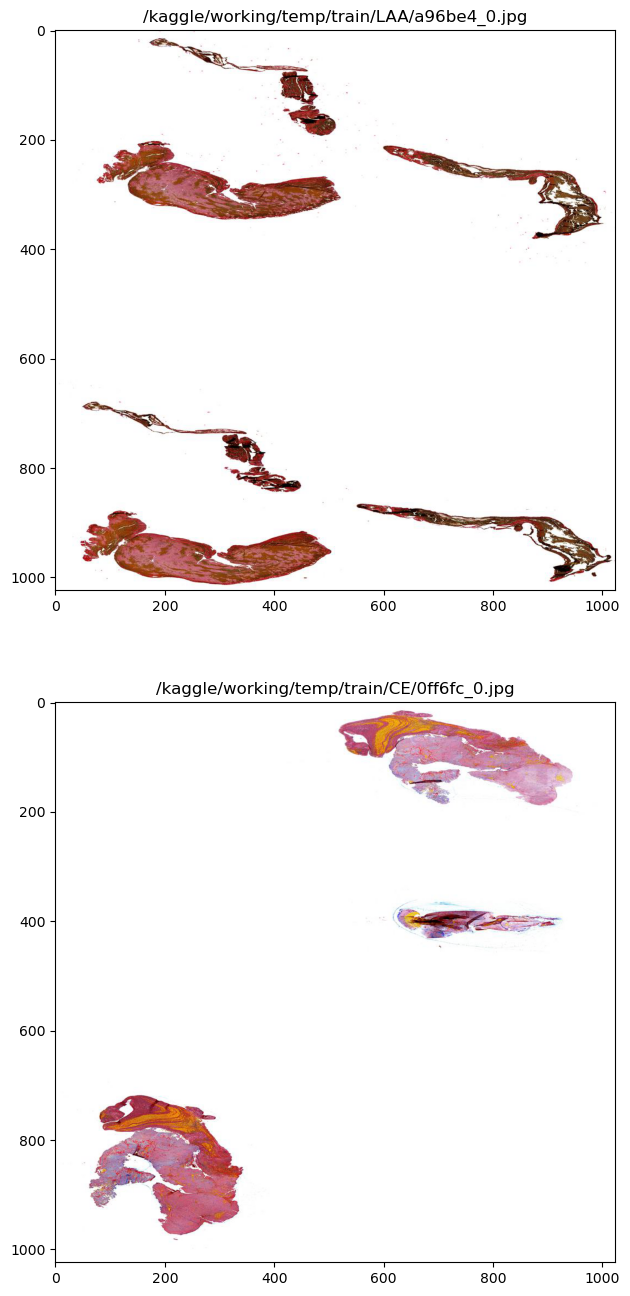

In [24]:
train_image_loader.show_images()

In [25]:
other_images = ImageLoader.build(df.other_df, config.other_dir, config.temp_train_dir).owner()

. . . . . . . . . . 10 images are loaded from /kaggle/input/mayo-clinic-strip-ai/other/ to /kaggle/working/temp/train/ in 133.42520191099993 seconds, 0 are skipped among which.


In [26]:
other_image_loader = ImageLoader(other_images)

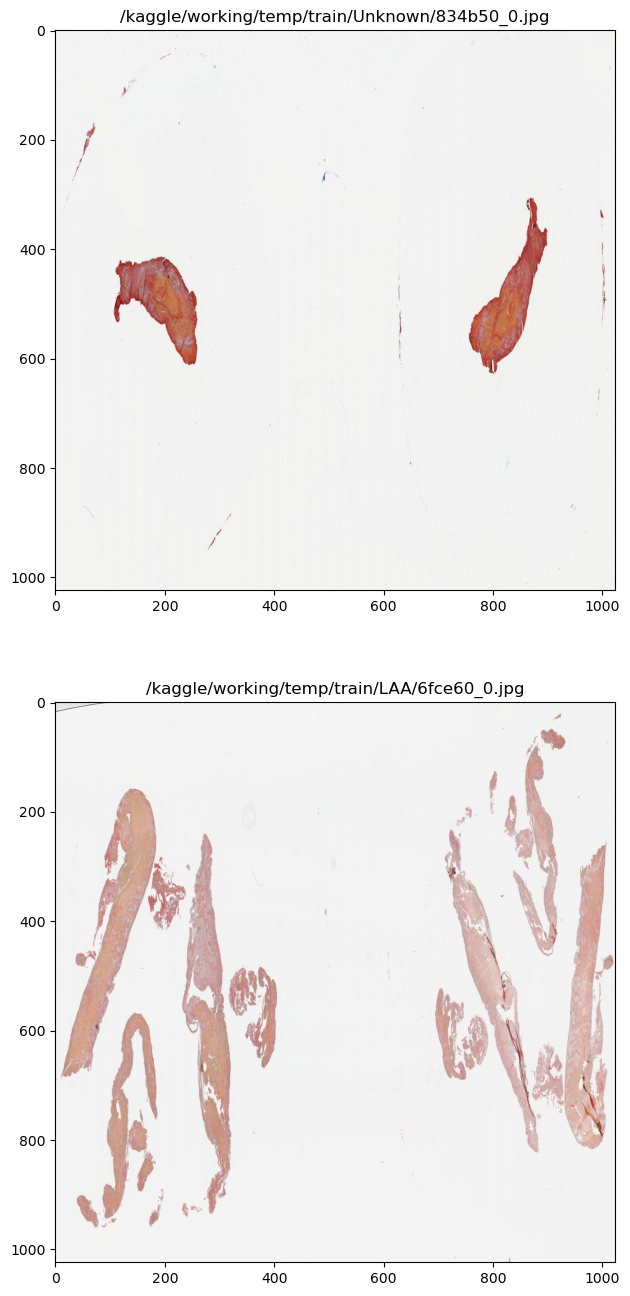

In [27]:
other_image_loader.show_images()

In [28]:
ds = DatasetBuilder.build([train_images, other_images]).owner()

Found 20 files belonging to 3 classes.
Using 17 files for training.
Found 20 files belonging to 3 classes.
Using 3 files for validation.


In [29]:
ds_loader = DatasetBuilder(ds)

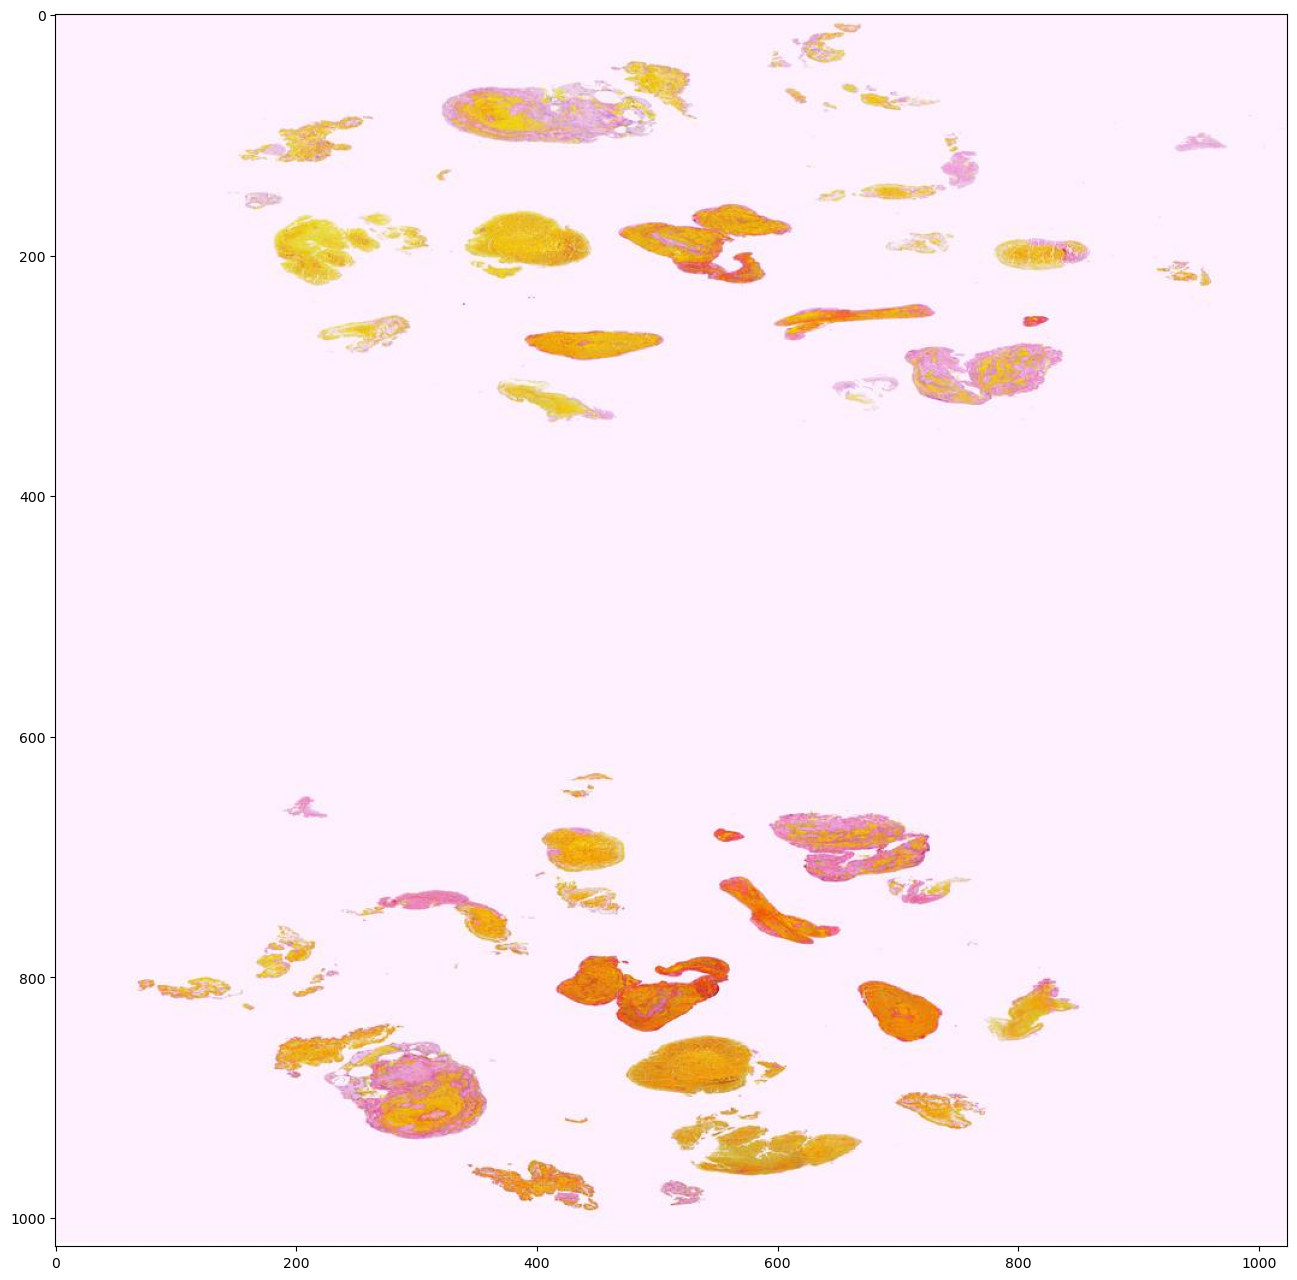

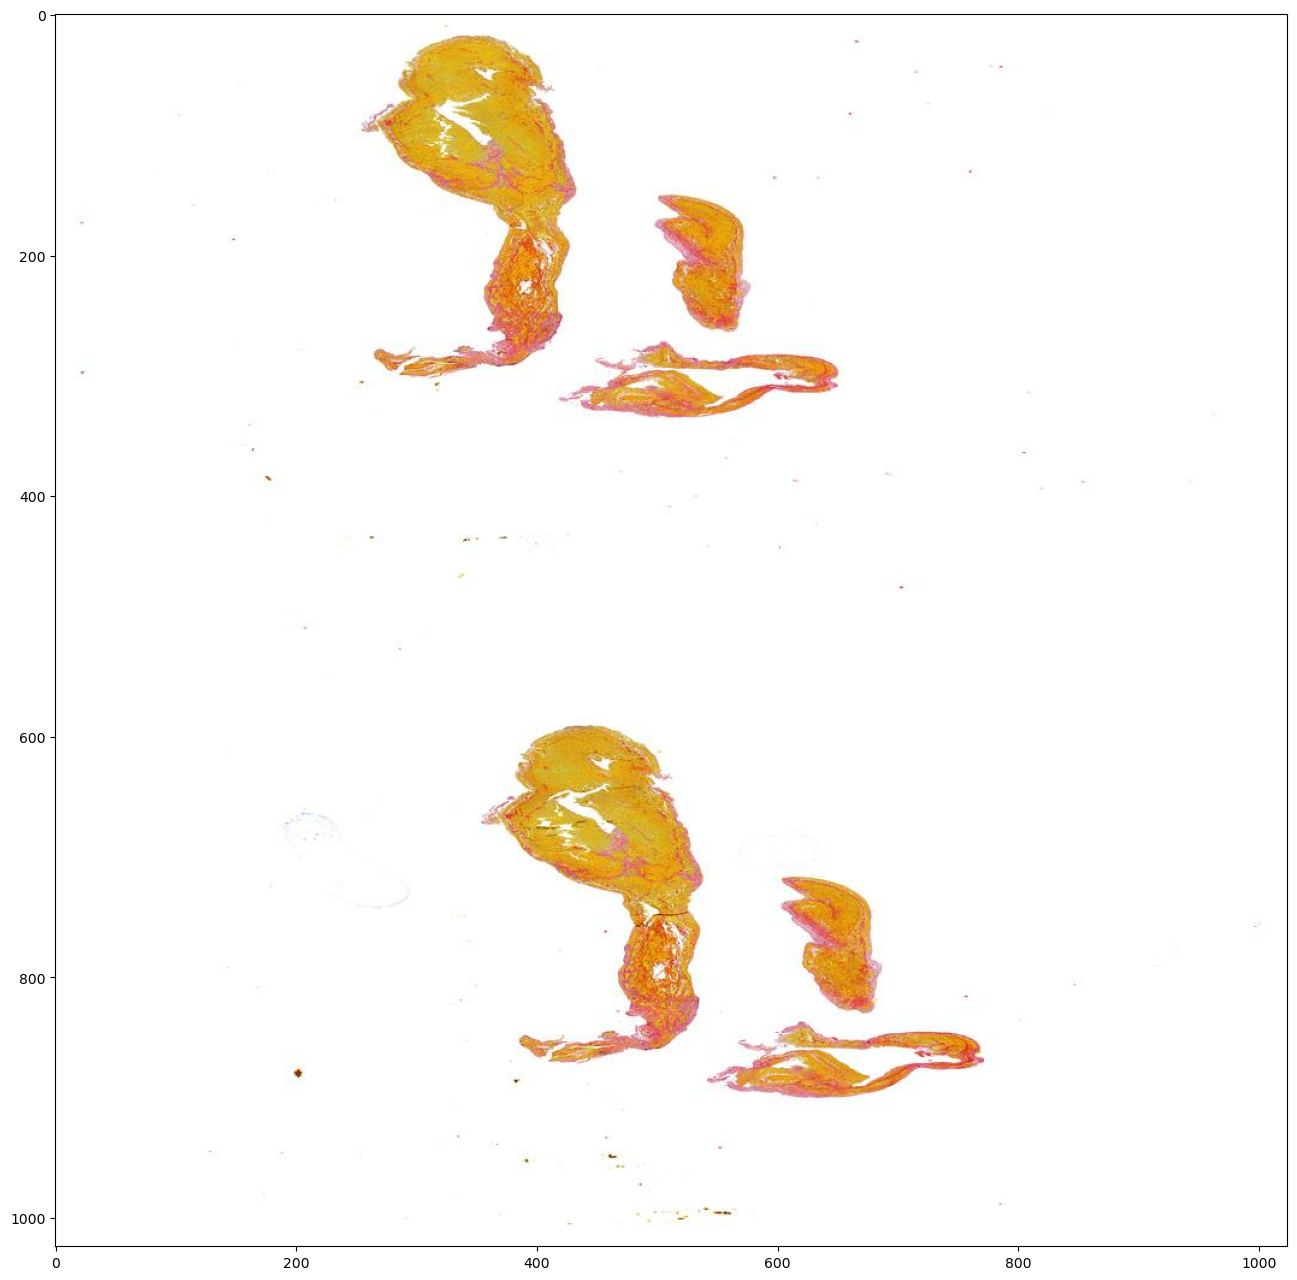

In [30]:
ds_loader.show_images()

In [55]:
ds.train_ds_.class_names

['CE', 'LAA', 'Unknown']

In [56]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
class Model:
    def __init__(self, ds):
        self.ds = ds
        self.history = None        
        self.opt = Adam()
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metrics = ['accuracy']
        self.callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]

        self.model = self.build_model()
        
    def fit(self, ds = None, epochs = 10):
        if ds == None:
            ds = self.ds
        self.history = self.model.fit(
            ds.train_ds_, 
            validation_data = ds.val_ds_,
            epochs = epochs,
            callbacks = self.callbacks
        )

     
    def build_model(self):
        # Input and augment layers
        input_shape = ds.train_ds_.element_spec[0].shape[1:]
        i = tf.keras.layers.Input(shape=input_shape)
        x = tf.cast(i, tf.float32)
        x = tf.keras.layers.RandomRotation(0.2)(x)
        x = tf.keras.layers.RandomFlip()(x)
        x = tf.keras.layers.RandomZoom(0.2)(x)
        
        #Core processing layers, pre-trained
        base_model = ResNet50V2(include_top = False, classes = len(self.ds.train_ds_.class_names))
        base_model.trainable = False      
        x = preprocess_input(x) 
        x = base_model(x,training = False)
        
        #Output layers
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        o = tf.keras.layers.Dense(len(self.ds.train_ds_.class_names))(x)
        
        m = tf.keras.Model(i,o)
        m.compile(
            optimizer = self.opt,
            loss = self.loss,
            metrics = self.metrics
        )
        return m


In [57]:
class ModelVisualization:
    def __init__(self, model: Model):
        self.model = model
    
    def show_history(self):
        #The plot function referrs to the code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
        history = self.model.history.history
        plt.plot(history['accuracy'],'*-')
        plt.plot(history['val_accuracy'],"x-")
        plt.plot(history['loss'],'*-')
        plt.plot(history['val_loss'],'x-')

        plt.title('model accuracy and loss')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['accuracy-train', 'accuracy-val', "loss-train", "loss-val"], loc='best')
        plt.grid()
        plt.show()


In [58]:
m = Model(ds)

In [59]:
m.fit()

Epoch 1/10
17/17 [==============================] - 48s 2s/step - loss: 260.3707 - accuracy: 0.4118 - val_loss: 314.3300 - val_accuracy: 0.3333
Epoch 2/10
17/17 [==============================] - 41s 2s/step - loss: 113.0551 - accuracy: 0.5882 - val_loss: 157.1968 - val_accuracy: 0.3333
Epoch 3/10
17/17 [==============================] - 39s 2s/step - loss: 31.3065 - accuracy: 0.5882 - val_loss: 314.2683 - val_accuracy: 0.0000e+00


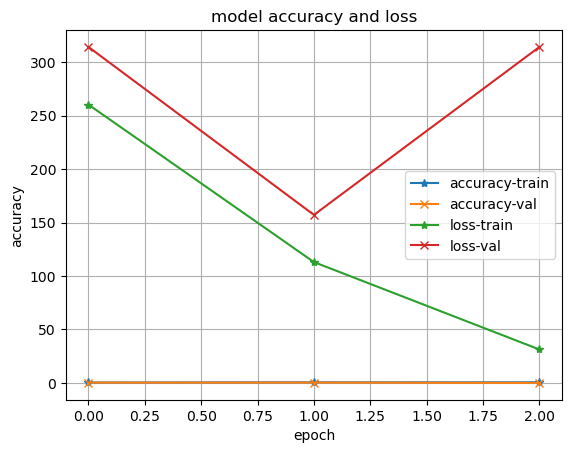

In [60]:
vm = ModelVisualization(m)
vm.show_history()

In [64]:
class Predictor:
    def __init__(self, model: tf.keras.Model, from_path, to_path):
        self.model = model
        #self.model.add(tf.keras.layers.Softmax())
        self.from_path = from_path
        self.to_path = to_path
        self.df = None
        self.prepare()
        self.pred = self.test()
        self.submit()
    def prepare(self):
        test_files = np.array(os.listdir(self.from_path))
        self.df = pd.DataFrame(test_files, columns=['image_id'])
        self.df = self.df.applymap(lambda x: os.path.splitext(x)[0])
        ImageLoader.build(self.df, self.from_path, self.to_path)
        
    def test(self):
        test_files = np.array(os.listdir(self.to_path))
        self.df = pd.DataFrame(test_files, columns=['image_id'])
        ds_gen = tf.keras.preprocessing.image.ImageDataGenerator()
        ds = ds_gen.flow_from_dataframe(
            self.df,
            self.to_path,
            class_mode=None,
            shuffle= False,
            x_col = 'id',
            y_col = None,
            target_size = Constants.TARGET_SIZE
        )

        y_pred_prob = self.model.predict(ds)
        #y_pred = tf.keras.np_utils.probas_to_classes(y_pred_prob)
        return y_pred_prob
    
    def submit(self):
        return
        self.df = self.df.applymap(lambda x: os.path.splitext(x)[0])

        self.df['label'] = self.pred
    def dump(self):
        print(self.pred.shape)
        print(self.pred)
        

In [ ]:
predictor = Predictor(m.model,config.origin_test_dir, config.temp_test_dir)

. 

In [40]:
test_files = np.array(os.listdir(config.origin_test_dir))

In [41]:
print(test_files)

['006388_0.tif' '00c058_0.tif' '008e5c_0.tif' '01adc5_0.tif']


In [44]:
test_df = pd.DataFrame(test_files, columns=['image_id']) 

In [46]:
test_df = test_df.applymap(lambda x: os.path.splitext(x)[0])

In [47]:
test_df

,image_id
0,006388_0
1,00c058_0
2,008e5c_0
3,01adc5_0


In [ ]:
class ImageLoader:
    def __init__(self, 
                 df, 
                 directory
                ):
        self.df = df
        self.directory = directory
        
    def load_one(self, id, category):

    
    return image
        

In [ ]:
#!pip uninstall PIL
#!python3 -m pip install --upgrade pip
#!python3 -m pip install --upgrade Pillow

## Exploratory Data Analysis (EDA)
The original data includes two sets, one for traning, the other one for testing. The preparing procedure put the training data to the train_dir/{class_name}, the testing data is put to the test_dir.
In the following sections, we will have initial analysis and visualization of the data.

The number of images for tranning is 220,025, and also verify the name is as expected.

In [ ]:
images = list(train_path.glob('*/*.jpg'))
image_count = len(images)
print("Number of images:",image_count)
print("First image:", images[0])

Cross verify the data by checking the tain_csv file provided along with the data.
The csv file includes the file id (filename excluding the extention) and the label.

In [ ]:
train_df = pd.read_csv(train_csv)
train_df.info()
train_df.head()

Have a glance of the statistics information of the training data from the csv file. From the data, 60% of the training images are not detected with cancer (marked as "Negative" in the pie chart), and 40% are detected with cancer (marked as "Positive")

In [ ]:
train_df['label'].value_counts()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['Negative', 'Positive']
plt.pie(train_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

Cross check the raw data with the files in the traning directory. The data matches with the csv file.

In [ ]:
images_true = list((pathlib.Path(dir_true).with_suffix('')).glob('*.jpg'))
image_count_true = len(images_true)
print("Number of images with cancer being detected:",image_count_true)

images_false = list((pathlib.Path(dir_false).with_suffix('')).glob('*.jpg'))
image_count_false = len(images_false)
print("Number of images with cancer not being detected:",image_count_false)

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_verify, y_train, y_verify = train_test_split(X, y, random_state=13, train_size=0.8)
#print(len(X_train), len(X_verify), len(y_train), len(y_verify))

Take some of the training images to be shown on the screen, the first set are positive images and the second set are negative images. 

In [ ]:
import PIL
import PIL.TiffImagePlugin
from PIL import Image

In [ ]:
fig_width = 5
fig_height = 5
fig,ax = plt.subplots(fig_height,fig_width)

print("Sample images with cancer being detected:")
for i in range(fig_width * fig_height):
    with open(images_true[i], "rb") as f:
        img = Image.open(f)
        ax[i%fig_height][i//fig_width].imshow(img)

In [ ]:
fig_width = 5
fig_height = 5
fig,ax = plt.subplots(fig_height,fig_width)
        
print("Sample images with cancer not being detected:")
for i in range(fig_width * fig_height):
    with open(images_false[i], "rb") as f:
        img = Image.open(f)
        ax[i%fig_height][i//fig_width].imshow(img)

To process the mimages, we need to know the size attibute of the images, it's (96,96) as shown below.

In [ ]:
print(Image.open(images[0]).size)

Generate then load the training image dataset with image_dataset_from_directory API from the directory. Split 20% from the dataset to be used for validation.

Confirm all training files are in place again.

In [ ]:
print("image_count:",len(images), image_count)
list_ds = tf.data.Dataset.list_files(str(train_path/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

In [ ]:
labels = train_df['label'].unique()
print(labels)

In [ ]:
img_size = Image.open(images[0]).size
class_names = ['0', '1']
batch_size = 32
orig_train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)


In [ ]:
orig_val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Check the type of the dataset and the information of elements in the dataset.

In [ ]:
print(orig_train_ds, "\n", orig_val_ds)

It indicates that each batch includes 32 images, among which, each image is 96*96 colored with RGB

In [ ]:
for image_batch, labels_batch in orig_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

## NN Model Architecture 
The high level architecture of the training network are referring to the tensorflow training material. On top of the referrd architecture, in this practice, several different modles with changing the hyper parameters such as different activation function and different loss funtion are tried to find the best one.
To have better performance, preloaded mecahnism is included.

In [ ]:
from tensorflow.keras import layers

Preload the dataset to cache to accelarate the training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = orig_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = orig_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Try the model with different hyper parameters to get the best one, to reduce the time, the epochs for each parameters set is set to 5, it may not nbe very accurate.
GPU is enabled.

In [ ]:
hyper_params = [
  {
    'num_classes':2,
    'activation':'relu',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'sigmoid',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'softmax',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'relu',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  },
  {
    'num_classes':2,
    'activation':'sigmoid',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  },
  {
    'num_classes':2,
    'activation':'softmax',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  }
]

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam()

best_model = None
best_param = None
best_result = 0
for p in hyper_params:
    print("Model params:",p)
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(img_size[0],img_size[1],3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        #tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=p['activation']),
        tf.keras.layers.Dense(p['num_classes'])
    ])

    model.compile(
      opt,
      loss=p['loss'],
      metrics=['accuracy'])
    
    model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=5
    )
    
    metrics = model.get_metrics_result()
    acc = metrics['accuracy'].numpy() #- metrics['loss'].numpy()
    if acc > best_result:
        best_model = model
        best_param = p
        best_result = acc

Summary of the best model and the corresponding hyper-parameters.

In [ ]:
model = best_model
model.summary()
model.get_metrics_result()


In [ ]:
print("Parameter:", best_param)

To get better result, retrain the best model with more epochs(15) and early-stop callbacks.  The early-stop callbacks will cause the training to be stopped when the val_accuracy decreases in two continous rounds. With the early-stop mechanism, it can avoid significant overfitting problem.
To prevent overfitting further, the L2 regularity and drop-out were added initially, but the final result was very bad, so the two groups are removed from the final model.

The model includes the following layers:
1. Preprocessing (Rescale) and augument (Flip) layer
2. Output layer
3. 3 hidden CNN layer with 64*3 nodes per layer and 3 hidden pooling layer
4. Optimization algorithm: Adam
5. Activation function:relu
6. Other parameters: default value

In [ ]:
from tensorflow.keras import regularizers
p = best_param
epochs = 15
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size[0],img_size[1],3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    #tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    

    tf.keras.layers.Flatten(),

    #Add L2 regulation and dropout layer to avoid overfitting
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    
    
    tf.keras.layers.Dense(128, activation=p['activation']),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(p['num_classes'])
])

model.compile(
    opt,
    loss=p['loss'],
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

The training is stopped earlier when epoch=5. Check the history information of the training.

In [ ]:
history = model.history.history
print(history.keys())
history

In [ ]:
#The plot function referrs to the code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy(history):
    plt.plot(history['accuracy'],'*-')
    plt.plot(history['val_accuracy'],"x-")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()
# summarize history for loss
def plot_loss(history):
    plt.plot(history['loss'],'*-')
    plt.plot(history['val_loss'],'x-')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()

In [ ]:
plot_accuracy(history)
plot_loss(history)

Refer to the tutorial, to make the probability more obvious, a softmax layer is added as the latest layer of the model.

## Test
Before testing, a softmax layer is added to the model to make the probability more obvious.
The test images are from the previously prepared test directory.
To make the result clearer, a pandas dataframe is created for the record.

Add softmax layer

In [ ]:
model.add(tf.keras.layers.Softmax())

Load data and create the dataframe respectively.

In [ ]:
test_files = np.array(os.listdir(test_dir))

In [ ]:
test_df = pd.DataFrame(test_files, columns=['id'])
print(test_df)

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator() #rescale is embedded in the model, no pre-rescaling
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    class_mode=None,
    shuffle= False,
    x_col = 'id',
    y_col = None,
    target_size = img_size
)

Predict. The result of the prediction is the probability of each class_name per record. The probability is mapped to the class_names then put to the dataframe at the end. 

In [ ]:
pred = model.predict(test_ds)

In [ ]:
print(pred.shape)
print(pred)

In [ ]:
test_df = test_df.applymap(lambda x: os.path.splitext(x)[0])

In [ ]:
pred = pd.DataFrame(pred)
test_df['label'] = pred.apply(np.argmax, axis=1)

In [ ]:
test_df

In [ ]:
test_df.to_csv('submission.csv',index=False)

In [ ]:
test_df['label'].value_counts()

In [ ]:
labels = ['Negative', 'Positive']
plt.pie(test_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

In [ ]:
plt.pie(train_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

## Conclusion and Analysis
From the statistics information of training data, the percentage of negative and positive are 60% and 40% respectively. The statistics of the predicted testing data indicates the percentage of negative and positive are 66% and 34% respectively.
As a rough estimation, there's 6% gap between the distribution of the prediction and the real distribution, which means the accuracy of the prediction(testing) is less than 90% (1-6/60), considering there are also some false positive and false negative, the accuracy of the prediction could be around 75% to 80%.
There are some improvements can be applied to get better result.
1. Use tiff format directly.
2. Fine tune with trying more different hyper-parameters 
3. Add rotation and other more image augumentation (it does not work in my environment however)
4. Enhance the network